Copy files to project

In [1]:
import os
from pathlib import Path
from shutil import copyfile
import re 
import platform
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import re
import pickle



In [2]:
# load everything 

metadata_calibre = pickle.load(open( "pickled_metadata/calibre_metadata.p", "rb" ))

metadata_goodreads = pickle.load(open( "pickled_metadata/metadata_goodreads.p", "rb" ))




In [3]:

#G = pickle.load(open( "pickled_graphs/small_graph.p", "rb" ))
G = pickle.load(open( "pickled_graphs/complete_graph_by_script.p", "rb" ))

# Plot Graph Data and export json to use on web page!

In [4]:
pg = nx.pagerank(G)

sorted(pg.items(), key=lambda item: item[1],reverse=True)[:10]


[('The Prince', 0.008243125615852585),
 ('Hamlet', 0.008124506940106345),
 ('The Divine Comedy', 0.004743886953596293),
 ('Essays', 0.0045430241026646785),
 ('Romeo and Juliet', 0.004452271126696995),
 ('The Art of War', 0.0035592485099391327),
 ('Sun Tzu', 0.0035592485099391327),
 ('Phaedrus', 0.0034722861174035433),
 ('Harvest', 0.003405304583741002),
 ('Poetics', 0.0030294541839440948)]

In [5]:
G.remove_nodes_from(list(nx.isolates(G)))

## Export Full graph data

In [6]:

import math


Bad key "text.kerning_factor" on line 4 in
/home/lira/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


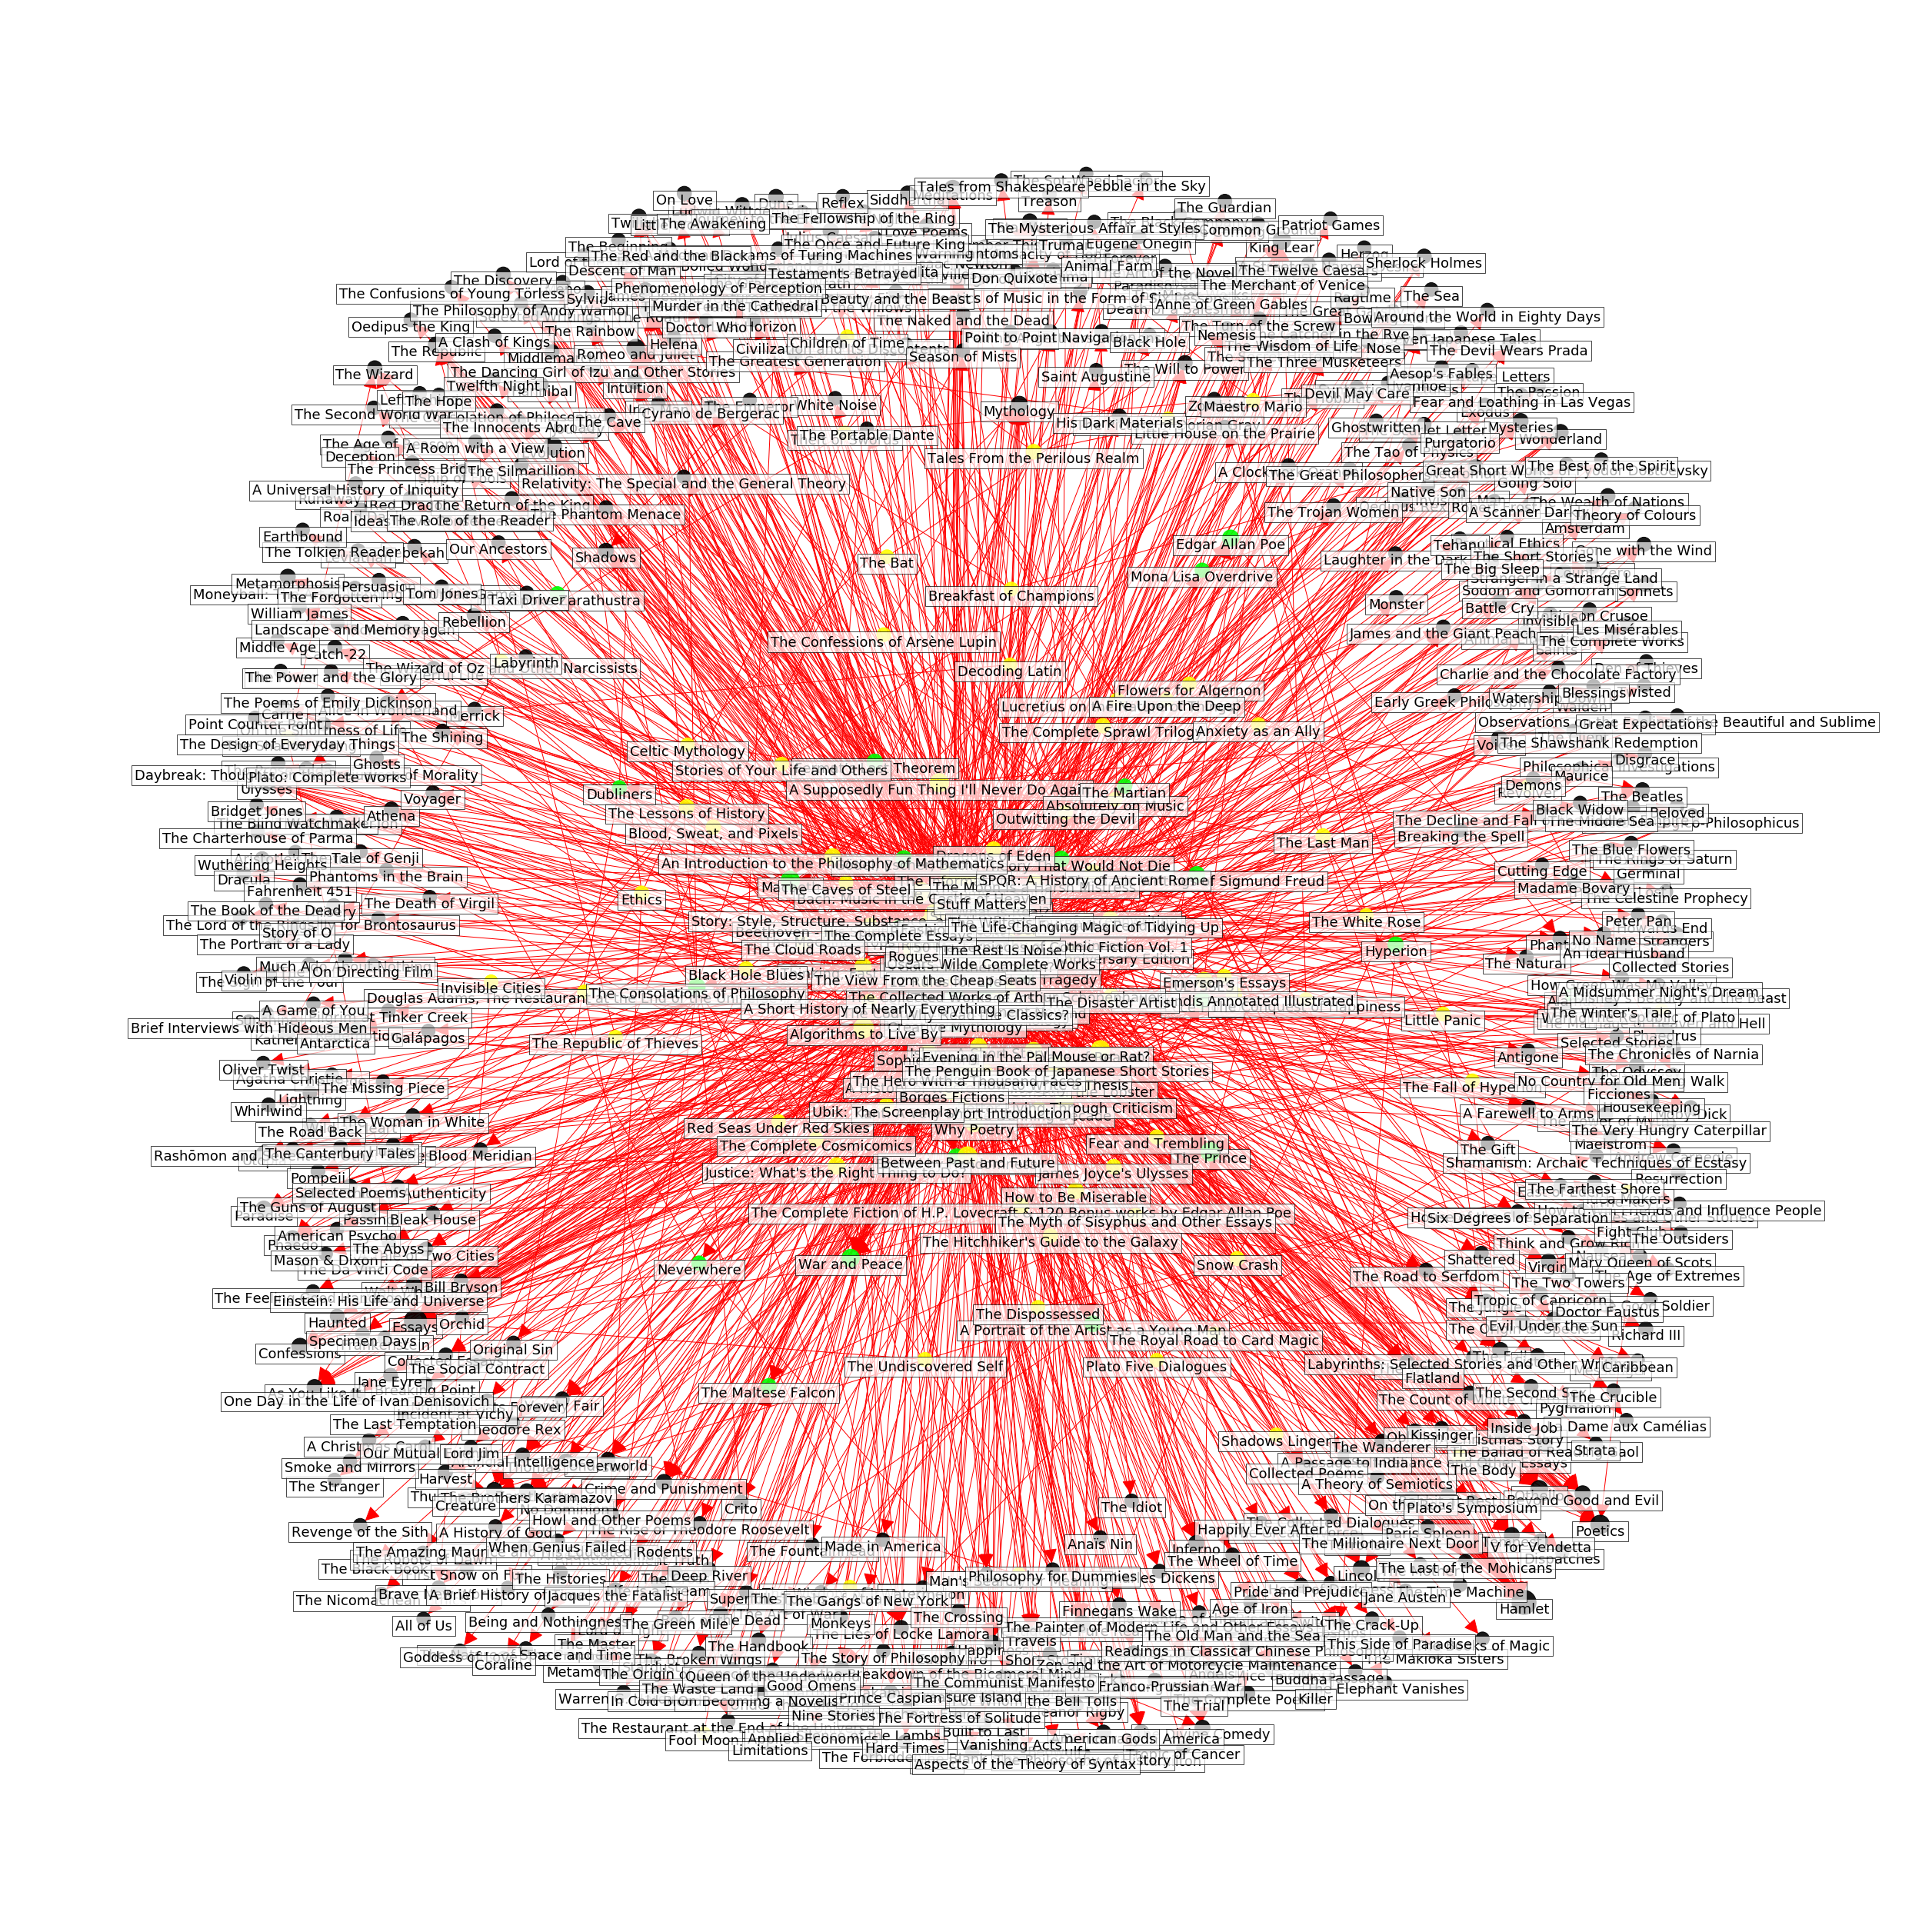

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(35, 35),)


len_pred = [len(list(G.predecessors(v))) for v in G]

reds = [math.ceil(float(i)/sum(len_pred)) for i in len_pred]

len_sucs = [len(list(G.successors(v))) for v in G]

greens = [math.ceil(float(i)/sum(len_sucs)) for i in len_sucs]


nodecolor = [ (1-r,g,0,1) for r,g in zip(reds,greens)]




nodesize = [(len(list(G.predecessors(v))) +len(list(G.successors(v))))  * 15 + 300 for v in G]

#pos = nx.kamada_kawai_layout(G)
# pos = nx.random_layout(G)
pos = nx.spring_layout(G,k=0.15,iterations=20)


edgewidth = [ 1 for u, v in G.edges()]

# Visualize graph components
nx.draw_networkx_edges(G, pos, arrowsize=40,arrowstyle="-|>",edge_color='r', arrows=True)

nx.draw_networkx_nodes(G, pos, node_size=nodesize, node_color=nodecolor, alpha=0.9)

label_options = {"fc": "white", "alpha": 0.7}

nx.draw_networkx_labels(G, pos, font_size=18, bbox=label_options,verticalalignment='top')

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.savefig('out.png');


In [8]:
xy = [ (xy[0],xy[1]) for idd,xy in pos.items() ]

x = [x for x,_ in xy]
y = [y for _,y in xy]

In [9]:
import numpy as np




xy_pixels = ax.transData.transform(np.vstack([x,y]).T)
xpix, ypix = xy_pixels.T

# In matplotlib, 0,0 is the lower left corner, whereas it's usually the upper 
# left for most image software, so we'll flip the y-coords...
width, height = fig.canvas.get_width_height()
ypix = height - ypix

pos_x = []
pos_y = []
for xp, yp in zip(xpix, ypix):
    pos_x.append(xp)
    pos_y.append(yp)


In [10]:


def categorize_pub_date(year):
    """
    a : classicos < 500
    b : medieval  500 < x < 1400
    c : renascimento/iluminismo 1400 < 1700
    d : moderno   1700 < x < 1900
    3 : contemporaneo > 1900
    """
    try:
        year = int(year)

        if year <= 500:
            return 'a'
        elif (year > 500) & (year <= 1400):
            return 'b'
        elif (year > 1400) & (year <= 1700):
            return 'c'
        elif (year > 1700) & (year <= 1900):
            return 'd'
        elif year > 1900:
            return 'e'
    except: 
        return 'e'


### Get more metadata to send to D3

In [11]:
nodes = []

str_to_id = {}

pubdates = []


# NODE ID IS NOT THE SAME AS METADATA ID 
# PASS NODE ID TO JSON 
for (node_id,data),px,py,ndsize in zip(enumerate(G.nodes.data()),pos_x,pos_y,nodesize):
    v,data_node = data
    str_to_id[v]=node_id
    #px,py = pos[v][0],pos[v][1]
    
    
    if not data_node:
        is_goodreads = 0
        # try to extract pubdate from metadata if no alias
        try:
            row = metadata_calibre.query(f'clean_title=="{v}"')
            author = row.authors.iloc[0]
            pubdate = re.match(r'(^\d\d\d\d).*$',row.pubdate.iloc[0])[1]
        except Exception:
            # look for book whose alias is this
            flag_found = False
            for id_book,aliases_list in zip(metadata_calibre.index,metadata_calibre['aliases']):
                if v in aliases_list:
                    flag_found = True
                    author = metadata_calibre[metadata_calibre.index == id_book].authors.iloc[0]
                    pubdate = re.match(r'(^\d\d\d\d).*$',metadata_calibre[metadata_calibre.index == id_book].pubdate.iloc[0])[1]
    else:
        
        is_goodreads = 1
        try:
            row = metadata_goodreads.query(f'clean_title=="{v}"')
            author = row.authors.iloc[0]
            pubdate = row.year_first_published.values[0]
        except Exception:
            # look for book whose alias is this
            flag_found = False
            for id_book,aliases_list in zip(metadata_goodreads.bookID,metadata_goodreads['aliases']):
                if v in aliases_list:
                    flag_found = True
                    author = metadata_goodreads[metadata_goodreads.bookID == id_book].authors.iloc[0]
                    pubdate = metadata_goodreads[metadata_goodreads.bookID == id_book].year_first_published.values[0]
        


    pubdate = categorize_pub_date(pubdate)         

    
    nodes.append({"name": v,"label":v,"id":node_id,"px":px,"py":py,"category_date":pubdate,"authors":author,"nodesize":ndsize/30,"is_goodreads":is_goodreads})
    
links = []
for i,v in enumerate(G.edges):
    links.append({"source": str_to_id[v[0]],"target":str_to_id[v[1]],"type":""})


In [12]:
# assert nodes with unique ids

In [13]:
import json
graph_data = {"nodes":nodes,"links":links}#,"pos":poss}
with open('web/graph.json', 'w') as f:
    json.dump(graph_data, f, indent=4)